In [1]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = True

# Importance of features

We all may have faced this problem of identifying the related features from a set of data and removing the irrelevant or less important features with do not contribute much to our target variable in order to achieve better accuracy for our model.

Feature selection, the process of finding and selecting the most useful features in a dataset, is a crucial step of the machine learning pipeline, which hugely impacts the performance of your model. Unnecessary features decrease training speed, decrease model interpretability, and, most importantly, decrease generalization performance on the test set.



## Problems with too many features

Irrelevant or partially relevant features can negatively impact model performance.

Curse of dimensionality: most of you probably heard of [Occam's razor](https://en.wikipedia.org/wiki/Occam%27s_razor), which clearly states that "The simplest explanation is most likely the right one."

## Benefit of feature selection:
1. improve accuracy. Models have increasing risk of overfitting with increasing number of features. Less misleading data to influence the model. 
2. reduce potential overfitting. Less redundant data means less opportunity to make decisions based on noise. 
3. speed up training. Training time increases exponentially with number of features.


## Current approaches of feature selection:

1. filter method: Pearson correlation of features, or Chi-sqaured 
2. Wrapper method: use machine learning method to select features, such as recursive feature elimination, etc. 
3. Embedded method: Lasso, Ridge
4. Boruta

# Data

In [2]:
RANDOM_SEED = 0

I am using make_sparse_uncorrelated from sklearn to generate a random regression problem with sparse uncorrelated design.

Only the first 4 features are informative, the remaining 6 features are useless.

> X ~ N(0, 1)
>
> y(X) = X[:, 0] + 2 * X[:, 1] - 2 * X[:, 2] - 1.5 * X[:, 3]


In [3]:
from sklearn.datasets import make_sparse_uncorrelated

X, y = make_sparse_uncorrelated(n_samples = 10000,
                               n_features=10,
                               random_state=RANDOM_SEED)

## Split train test data sets

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

## Normalization

In general, it is a good practice to do a normalization and/or standardization. 

But in this case, there is no need to do any normalization or standardization here given the inputs are the same scale. 

In [6]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

## Peak at distribution

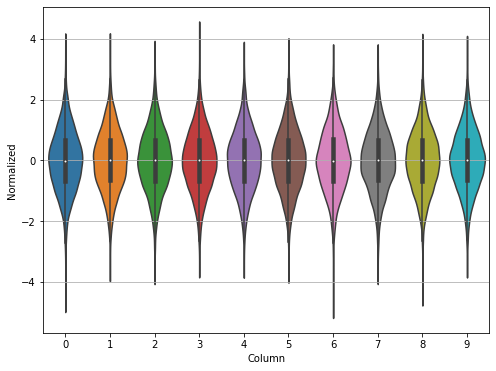

In [7]:
# Check distributions of first 10 columns
df_std = pd.DataFrame(X_train[:,:10]).melt(var_name = 'Column', value_name = 'Normalized')

ax = sns.violinplot(x ='Column', y='Normalized', data = df_std)
# _ = ax.set_xticklabels(np.arange(0, X.shape[1]))

# Compare different methods 

## Baseline

For simplicity purpose, I am going to only using one common model throughout for comparison. Other models, such as Random Forest and LassoCV are also used for feature selection purpose. After features are selected, apply the features selected to the same model for comparison. 

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

In [13]:
def eveluate_features(col_index):
    """Train the linear regression model with the columns provided and return with rsqaured and mae score"""
    model = LinearRegression()
    model.fit(X_train[:, col_index], y_train)
    
    pred = model.predict(X_test[:, col_index])
    
    r_squared = r2_score(y_test, pred)
    mae = mean_absolute_error(y_test, pred)
    return [r_squared, mae]

In [14]:
# Use all 10 features 
full_feature = np.arange(0, X_train.shape[1])
full_feature.shape

(10,)

In [15]:
performance = {}
performance['Baseline']= eveluate_features(full_feature)

performance

{'Baseline': [0.9234195446473121, 0.7911303477559977]}

## Filter method

Another way to select features is to only consider the features that strongly correlate with y-value. 

The disadvantage is the threshold is manually allocated, and sometimes the threshold is not easy to identify.

In [16]:
# Consolidate the features and y value
X_df = pd.DataFrame(X_train, columns= ['X_' + str(i) for i in range(X_train.shape[1])])
X_df['y'] = y_train

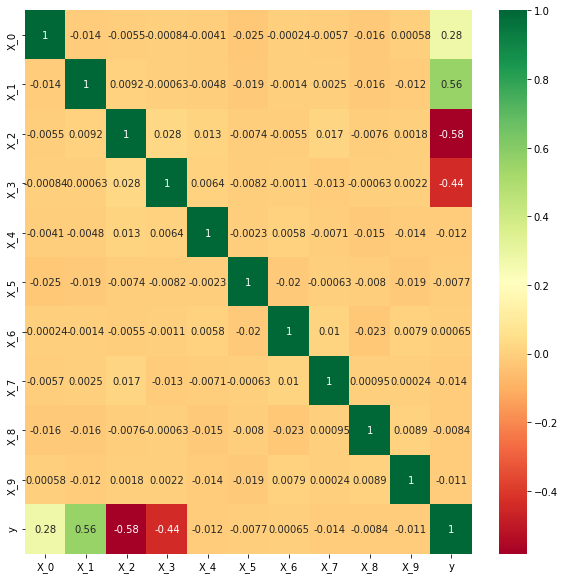

In [17]:
#plot heat map
plt.figure(figsize=(10,10))
g=sns.heatmap(X_df.corr(), annot=True, cmap="RdYlGn")

From the heatmap, it is pretty clear that the first 4 columns has the most predictive power, while the remainings are just random noises

In real life situation, the threhold might not be as easy to find as this example.

In [18]:
CORR_THRESHOLD = 0.2

correlations = (np.abs(X_df.corr().iloc[-1])> CORR_THRESHOLD)
del X_df

In [19]:
# Find the feature index 
correlations = correlations.reset_index()

# Remove last index because that is y
filtered_cols = correlations[correlations['y']>0].index.values[:-1]

# Total number of features that exceed threshold
filtered_cols.shape

(4,)

In [20]:
performance['Filter'] = eveluate_features(filtered_cols)
performance

{'Baseline': [0.9234195446473121, 0.7911303477559977],
 'Filter': [0.9235828822195473, 0.7901373968851749]}

Performance of the 4 features is better than baseline with 10 features 

## Wrapper method: 

A wrapper method needs one machine learning algorithm and uses its performance as evaluation criteria. This means, you feed the features to the selected Machine Learning algorithm and based on the model performance you add/remove the features. This is an iterative and computationally expensive process but it is more accurate than the filter method.

Sklearn has many packages that can select from: SelectFromModel, f_regression, RFE, mutual_info_regression, SelectKBest, chi2. 

In [21]:
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.ensemble import RandomForestRegressor

### Select from model

One of the more popular method is SelectFromModel from Sklearn. Basically, it chooses any estimator and fits data, then extracts feature importance from model and keeps only features that exceeds certain threshold. 

The downside of this is that the threshold is arbitrary allocated. 

In [22]:
%%time

# The most important parameter is threshold
# If “median” (resp. “mean”), then the threshold value is the median (resp. the mean) of the feature importances. 
# A scaling factor (e.g., “1.25*mean”) may also be used.
# The default value is 'mean'
estimator=LinearRegression()
selector = SelectFromModel(estimator,
                          threshold= 'median'
                          )
selector.fit(X_train, y_train)

CPU times: user 5.04 ms, sys: 1.77 ms, total: 6.81 ms
Wall time: 2.59 ms


SelectFromModel(estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                           n_jobs=None, normalize=False),
                max_features=None, norm_order=1, prefit=False,
                threshold='median')

In [26]:
selector_cols = selector.get_support()
selector_cols.sum()

5

In [27]:
performance['SelectFromModel'] = eveluate_features(selector_cols)
performance

{'Baseline': [0.9234195446473121, 0.7911303477559977],
 'Filter': [0.9235828822195473, 0.7901373968851749],
 'SelectFromModel': [0.9234707018574482, 0.7908415201898333]}

The method selected 5 features, 1 more than actual, and performance is slightly better than baseline 

### RFE

The Recursive Feature Elimination (RFE) method works by recursively removing attributes and building a model on those attributes that remain. 

- First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a coef_ attribute or through a feature_importances_ attribute. 
- Then, the least important features are pruned from current set of features. 
- Repeat procedure recursively on the pruned set until the desired number of features to select is eventually reached.

<img src = https://miro.medium.com/max/1400/1*qXqx7_hDtsO9ez7_nxSXOw.png>

In [28]:
%%time
estimator = LinearRegression()
selector = RFE(estimator, n_features_to_select=6, step=10) # You need to manually select the number of features
selector = selector.fit(X_train, y_train)

CPU times: user 14 ms, sys: 1.94 ms, total: 15.9 ms
Wall time: 4.27 ms


In [29]:
selector_cols = selector.get_support()
selector_cols.sum()

6

In [30]:
selector.ranking_

array([1, 1, 1, 1, 2, 2, 2, 1, 2, 1])

It picked the first 4 and the other 2 features since I am asking for 6 features 

In [31]:
performance['FeatureRanking'] = eveluate_features(selector_cols)
performance

{'Baseline': [0.9234195446473121, 0.7911303477559977],
 'Filter': [0.9235828822195473, 0.7901373968851749],
 'SelectFromModel': [0.9234707018574482, 0.7908415201898333],
 'FeatureRanking': [0.9234659648120749, 0.7907830473782319]}

## Embedded method

Embedded methods are iterative in a sense that takes care of each iteration of the model training process and carefully extract those features which contribute the most to the training for a particular iteration. 

Regularization methods are the most commonly used embedded methods which penalize a feature given a coefficient threshold.

In [32]:
from sklearn.linear_model import LassoCV

In [33]:
%%time
lass = LassoCV(cv= 5)
lass.fit(X_train, y_train)

CPU times: user 473 ms, sys: 9.75 ms, total: 483 ms
Wall time: 83.1 ms


LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [34]:
lass_cols = lass.coef_ !=0
lass_cols.sum()

7

In [35]:
performance['Lasso'] = eveluate_features(lass_cols)
performance

{'Baseline': [0.9234195446473121, 0.7911303477559977],
 'Filter': [0.9235828822195473, 0.7901373968851749],
 'SelectFromModel': [0.9234707018574482, 0.7908415201898333],
 'FeatureRanking': [0.9234659648120749, 0.7907830473782319],
 'Lasso': [0.9234745373339652, 0.790790676434184]}

## Boruta

Boruta has 2 advantages over the other feature selection models. 

1. Boruta creates shadow features and select features that have higher importance than randomly created ones. Firstly, Boruta creates duplicated features and shuffles the data from original feature to these features as shadow features. Then it uses an estimator to train model, and collect the importance (z-score) of all features. The features that are selecetd should be higher than the maximum importance of shadow features. The idea is that a feature is only useful if it is better than the best random feature. 

2. Binomial distribution. One iteration might have very random results with shadow features. The idea here is whenever a feature beats best randomized feature, the model gives it a hit. After 100 iterations, the number of hits a feature get follow binomial distribution, and 

The main disadvantage is computation time. 

Documentation https://github.com/scikit-learn-contrib/boruta_py

In [36]:
from boruta import BorutaPy

In [37]:
%%time
###initialize Boruta
forest = RandomForestRegressor(
   n_jobs = -1, 
   max_depth = 5
)

boruta = BorutaPy(
   estimator = forest, 
   n_estimators = 'auto',
   max_iter = 100 # number of trials to perform
)

### fit Boruta (it accepts np.array, not pd.DataFrame)
boruta.fit(X_train, y_train)

CPU times: user 1min 22s, sys: 652 ms, total: 1min 22s
Wall time: 13.9 s


BorutaPy(alpha=0.05,
         estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                         criterion='mse', max_depth=5,
                                         max_features='auto',
                                         max_leaf_nodes=None, max_samples=None,
                                         min_impurity_decrease=0.0,
                                         min_impurity_split=None,
                                         min_samples_leaf=1,
                                         min_samples_split=2,
                                         min_weight_fraction_leaf=0.0,
                                         n_estimators=63, n_jobs=-1,
                                         oob_score=False,
                                         random_state=RandomState(MT19937) at 0x7F7F58ED6050,
                                         verbose=0, warm_start=False),
         max_iter=100, n_estimators='auto', perc=100,
         random_stat

In [38]:
boruta_cols = boruta.support_
boruta_cols.sum()

4

In [39]:
performance['Boruta'] = eveluate_features(boruta_cols)
performance

{'Baseline': [0.9234195446473121, 0.7911303477559977],
 'Filter': [0.9235828822195473, 0.7901373968851749],
 'SelectFromModel': [0.9234707018574482, 0.7908415201898333],
 'FeatureRanking': [0.9234659648120749, 0.7907830473782319],
 'Lasso': [0.9234745373339652, 0.790790676434184],
 'Boruta': [0.9235828822195473, 0.7901373968851749]}

# Comparison

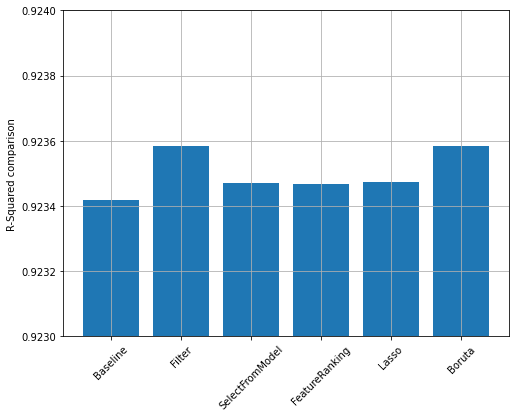

In [46]:
x = np.arange(len(performance))
test_r2 = [v[0] for v in performance.values()]

plt.ylabel('R-Squared comparison')
plt.bar(x, test_r2)
plt.ylim(0.923, 0.924)
plt.xticks(ticks = x, 
          labels = performance.keys(),
          rotation = 45)
_ = plt.show()

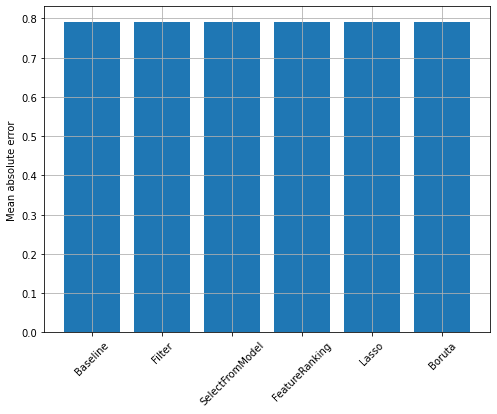

In [47]:
x = np.arange(len(performance))
metric_name = 'mean_absolute_error'

test_mae = [v[1] for v in performance.values()]

plt.ylabel('Mean absolute error')
plt.bar(x, test_mae)
plt.xticks(ticks = x, 
          labels = performance.keys(),
          rotation = 45)
_ = plt.show()

Timing:
- Baseline: 0  
- Filter: 0
- Wrapper: 
    - Select from model: 6.81 ms
    - RFE: 15.9 ms
- Embedded LassoCV: 483 ms
- Boruto: 1min 22s

# Conclusion 

Feature Selection as most things in Data Science is highly context and data dependent and there is no one stop solution for Feature Selection. 

The best way to go forward is to understand the mechanism of each methods and use when required.